# Neural Network Patient Matching

## Importing Dependencies

In [5]:
import chars2vec
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Loading Pre-Trained Model

In [3]:
c2v_model = chars2vec.load_model('eng_50')

## Data Pre-processing

In [4]:
df = pd.read_csv('augmented_data_with_errors.csv')

In [7]:
df.head()

,name,phone,address,postalZip,region,appointmentdate
0,Yvonne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
1,YvonnE Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,06-20-2023
2,Yvonne hua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
3,Yvnne Phua,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06-2023
4,Yvonne Phau,(833) 925-5254,Ap #437-2699 Sed Street,72001,Ohio,20-06


In [8]:
df.shape

(60000, 6)

## Descriptive Analysis

In [9]:
# 1. Descriptive Statistics
def descriptive_statistics(df):
    print("Descriptive Statistics:")
    print(df.describe())
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nData Types:\n", df.dtypes)



In [11]:
# 2. Data Visualization

# Univariate Analysis
def univariate_analysis(df, column):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Histogram of {column}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column].dropna())
    plt.title(f'Boxplot of {column}')

    plt.tight_layout()
    plt.show()

# Bivariate Analysis
def bivariate_analysis(df, x, y):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=df[x], y=df[y])
    plt.title(f'Scatter plot between {x} and {y}')

    plt.subplot(1, 2, 2)
    sns.lineplot(x=df[x], y=df[y])
    plt.title(f'Line plot of {x} vs {y}')

    plt.tight_layout()
    plt.show()



In [22]:
# 3. Correlation Analysis
# def correlation_analysis(df):
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
#     plt.title('Correlation Heatmap')
#     plt.show()
def correlation_analysis(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns to compute correlation.")
        return

    correlation_matrix = numeric_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=False, yticklabels=False)
    plt.title('Correlation Heatmap')
    plt.show()

# 4. Handling Missing Values
def missing_value_analysis(df):
    print("\nMissing Value Analysis:")
    print(df.isnull().sum())
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

Descriptive Statistics:
         postalZip
count  60000.00000
mean   54282.30000
std    23377.42683
min    12575.00000
25%    33455.25000
50%    55006.50000
75%    73365.00000
max    99811.00000

Missing Values:
 name               0
phone              0
address            0
postalZip          0
region             0
appointmentdate    0
dtype: int64

Data Types:
 name               object
phone              object
address            object
postalZip           int64
region             object
appointmentdate    object
dtype: object


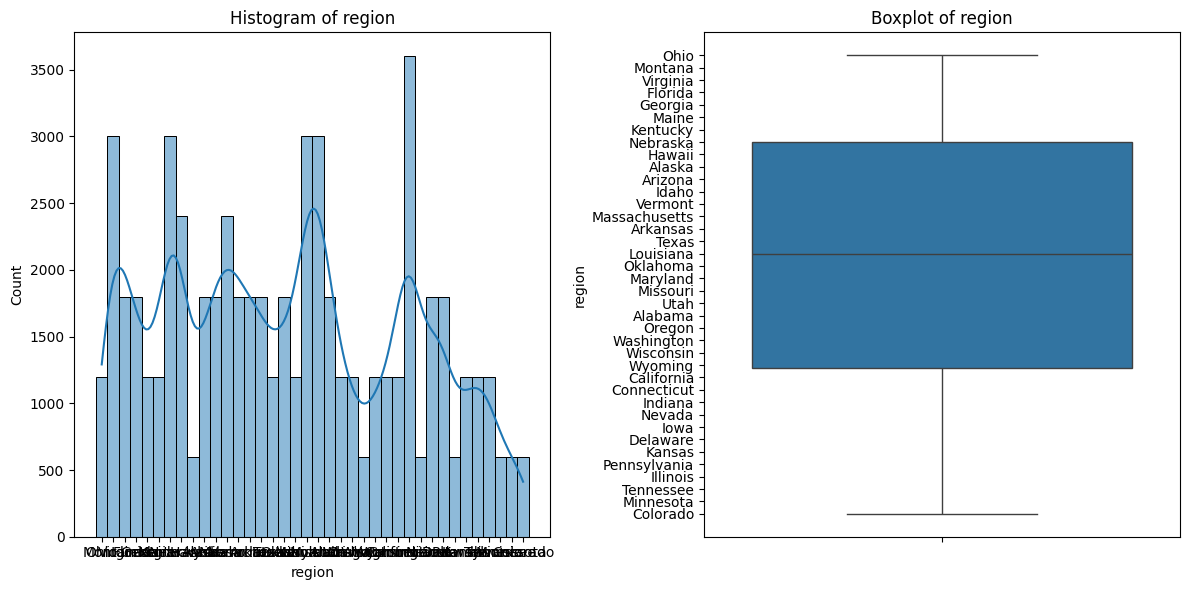

In [16]:
descriptive_statistics(df)
univariate_analysis(df, 'region')

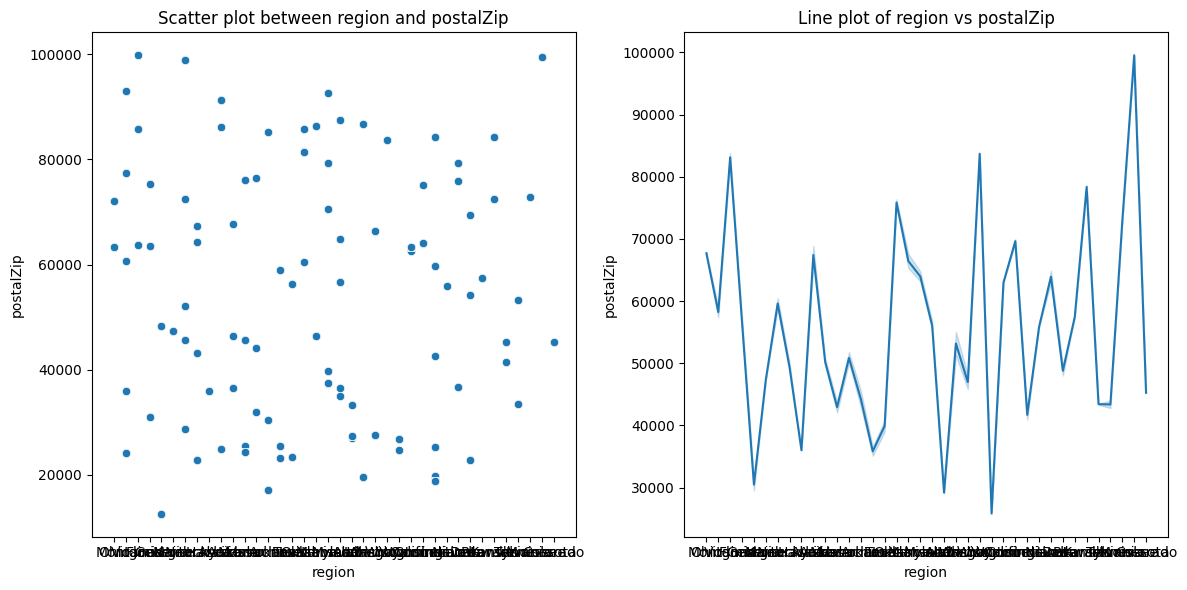

In [17]:
bivariate_analysis(df, 'region', 'postalZip')

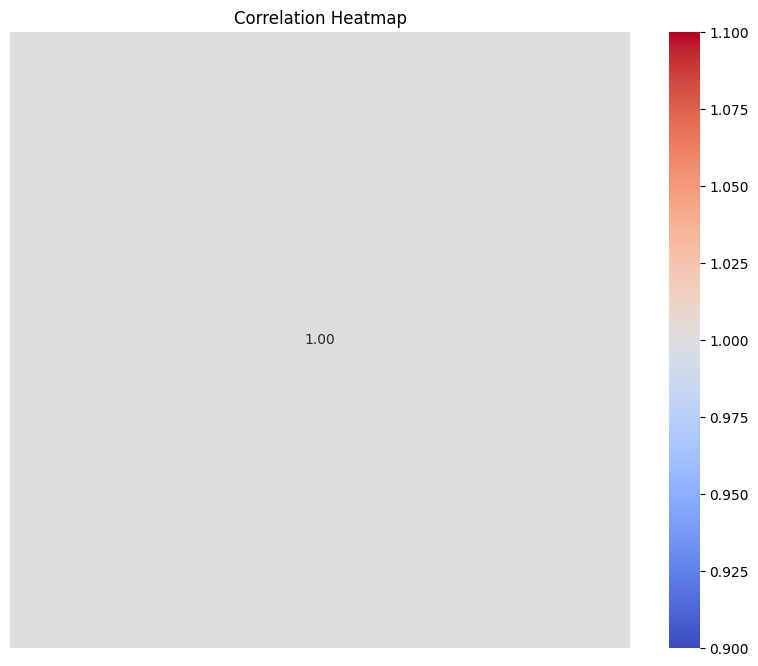

In [23]:
correlation_analysis(df)


Missing Value Analysis:
name               0
phone              0
address            0
postalZip          0
region             0
appointmentdate    0
dtype: int64


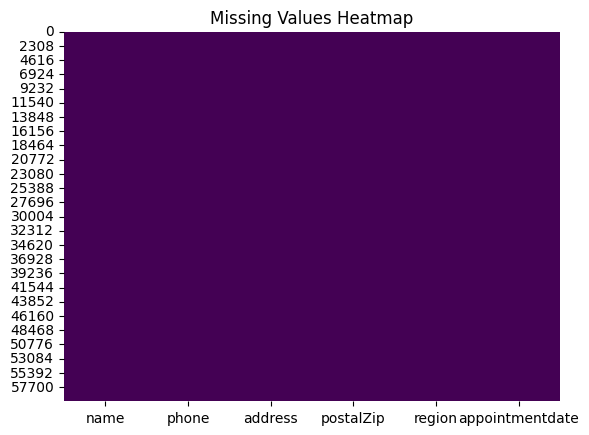

In [24]:
missing_value_analysis(df)